<a href="https://colab.research.google.com/github/Alafiade/IMPLEMENTATION-OF-UNSTRUCTURED-PRUNING-ON-A-RESNET101-MODEL/blob/main/Magnitude_based_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING  DEPENDENCIES

In [ ]:
!pip install split-folders
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import splitfolders
import torch.utils.data as data

DATA AQUISITION

In [ ]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 78% 17.0M/21.8M [00:01<00:00, 16.2MB/s]
100% 21.8M/21.8M [00:01<00:00, 15.7MB/s]


In [ ]:
!unzip satellite.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

DATA PREPROCESSING

In [ ]:
!pip install split-folders # Install splitfolders using pip
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders # Import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directories
data_dir = "/content/data"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Copying files: 5631 files [00:01, 5473.34 files/s]


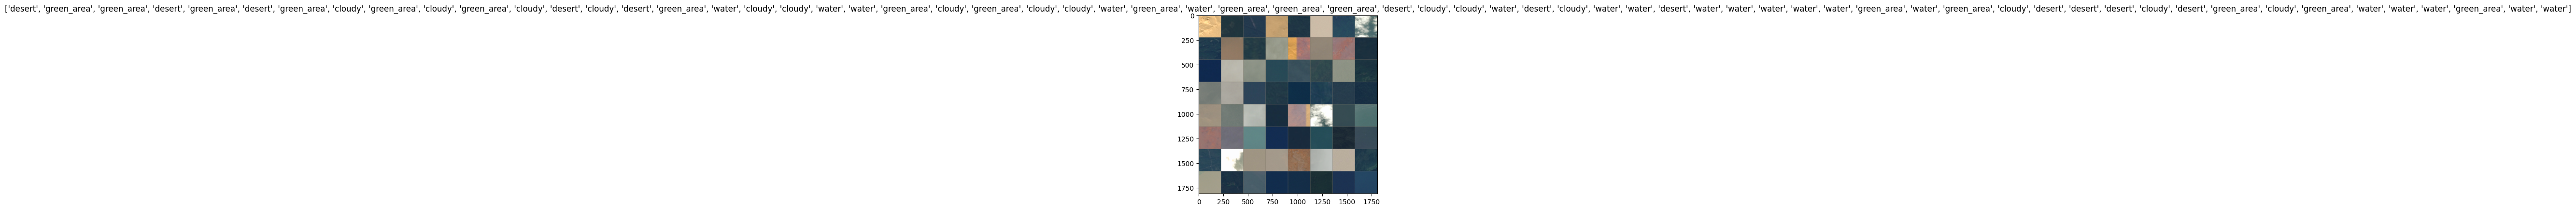

In [ ]:
#Displaying Validation Images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

IMPORTING RESNET 101 MODEL

In [ ]:
import torchvision.models as models

# Use models.resnet101() to access the model
model = models.resnet101(pretrained=True)
model.eval()

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IMPORTING THE SGD OPTIMIZER

In [ ]:
import torch.optim as optim
# Get parameters from the model you defined earlier (e.g., model)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

DEFINING LOSS FUNCTION

In [ ]:
import torch.nn  as nn
criterion = nn.CrossEntropyLoss()

TRAINING LOOP FOR THE RESNET101 MODEL

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)



                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 0.9187 Acc: 0.8621
Validation Loss: 0.0384 Acc: 0.9876
Epoch 2/20
----------
Training Loss: 0.0704 Acc: 0.9745
Validation Loss: 0.0498 Acc: 0.9849
Epoch 3/20
----------
Training Loss: 0.0484 Acc: 0.9836
Validation Loss: 0.0274 Acc: 0.9902
Epoch 4/20
----------
Training Loss: 0.0418 Acc: 0.9860
Validation Loss: 0.0177 Acc: 0.9947
Epoch 5/20
----------
Training Loss: 0.0322 Acc: 0.9887
Validation Loss: 0.0279 Acc: 0.9894
Epoch 6/20
----------
Training Loss: 0.0248 Acc: 0.9929
Validation Loss: 0.0251 Acc: 0.9938
Epoch 7/20
----------
Training Loss: 0.0298 Acc: 0.9893
Validation Loss: 0.0226 Acc: 0.9902
Epoch 8/20
----------
Training Loss: 0.0226 Acc: 0.9922
Validation Loss: 0.0227 Acc: 0.9956
Epoch 9/20
----------
Training Loss: 0.0188 Acc: 0.9933
Validation Loss: 0.0368 Acc: 0.9849
Epoch 10/20
----------
Training Loss: 0.0209 Acc: 0.9925
Validation Loss: 0.0130 Acc: 0.9956
Epoch 11/20
----------
Training Loss: 0.0185 Acc: 0.9944
Validation Loss: 0.037

SAVING RESNET101 MODEL

In [ ]:
torch.save(model.state_dict(),'model.pth')

IMPORTING PYTORCH'S PRUNING UTILITIES

In [ ]:
import torch.nn.utils.prune as prune


LOADING THE SAVED PRE-TRAINED RESNET 101

In [ ]:
model = models.resnet101()
model.load_state_dict(torch.load('model.pth'))

<ipython-input-13-820323ae5055>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

APPLYING UNSTRUCTURED PRUNING TO THE CONVOLUTIONAL LAYERS OF THE MODEL

In [ ]:
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    prune.random_unstructured(module, name='weight', amount=0.2) #Pruning 20% of the weights

PRINTING THE NUMBER OF NON-ZERO WEIGHTS IN EACH CONV LAYERS

In [ ]:
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    print(f'{name}: {module.weight.data.nonzero().size(0)} non-zero weights')

conv1: 7526 non-zero weights
layer1.0.conv1: 3277 non-zero weights
layer1.0.conv2: 29491 non-zero weights
layer1.0.conv3: 13107 non-zero weights
layer1.0.downsample.0: 13107 non-zero weights
layer1.1.conv1: 13107 non-zero weights
layer1.1.conv2: 29491 non-zero weights
layer1.1.conv3: 13107 non-zero weights
layer1.2.conv1: 13107 non-zero weights
layer1.2.conv2: 29491 non-zero weights
layer1.2.conv3: 13107 non-zero weights
layer2.0.conv1: 26214 non-zero weights
layer2.0.conv2: 117965 non-zero weights
layer2.0.conv3: 52429 non-zero weights
layer2.0.downsample.0: 104858 non-zero weights
layer2.1.conv1: 52429 non-zero weights
layer2.1.conv2: 117965 non-zero weights
layer2.1.conv3: 52429 non-zero weights
layer2.2.conv1: 52429 non-zero weights
layer2.2.conv2: 117965 non-zero weights
layer2.2.conv3: 52429 non-zero weights
layer2.3.conv1: 52429 non-zero weights
layer2.3.conv2: 117965 non-zero weights
layer2.3.conv3: 52429 non-zero weights
layer3.0.conv1: 104858 non-zero weights
layer3.0.conv2: 

FINETUNING THE PRUNED MODEL

In [ ]:
#Defining EarlyStopping
class EarlyStopping:
  def __init__(self, patience=5, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = None

  def __call__(self,val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
    elif val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter =  0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        if self.verbose:
          print('Early stopping triggered')
          return True
        return False

In [ ]:
# Define a new optimizer for the pruned model
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)

In [ ]:
# Training Loop for the pruned model

def train_model(model, criterion, optimizer, num_epochs=15, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it improves on validation accuracy
            if phase == 'Validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

                # Check for early stopping condition based on validation loss
                if early_stopping(epoch_loss):
                    break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model with early stopping
model = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
Training Loss: 0.0721 Acc: 0.9778
Validation Loss: 0.0266 Acc: 0.9894
Epoch 2/15
----------
Training Loss: 0.0456 Acc: 0.9867
Validation Loss: 0.0243 Acc: 0.9956
Epoch 3/15
----------
Training Loss: 0.0347 Acc: 0.9893
Validation Loss: 0.0150 Acc: 0.9982
Epoch 4/15
----------
Training Loss: 0.0305 Acc: 0.9918
Validation Loss: 0.0113 Acc: 0.9991
Epoch 5/15
----------
Training Loss: 0.0292 Acc: 0.9909
Validation Loss: 0.0153 Acc: 0.9938
Epoch 6/15
----------
Training Loss: 0.0232 Acc: 0.9938
Validation Loss: 0.0150 Acc: 0.9956
Epoch 7/15
----------
Training Loss: 0.0237 Acc: 0.9929
Validation Loss: 0.0136 Acc: 0.9965
Epoch 8/15
----------
Training Loss: 0.0212 Acc: 0.9947
Validation Loss: 0.0134 Acc: 0.9973
Epoch 9/15
----------
Training Loss: 0.0192 Acc: 0.9956
Validation Loss: 0.0089 Acc: 0.9982
Epoch 10/15
----------
Training Loss: 0.0191 Acc: 0.9942
Validation Loss: 0.0156 Acc: 0.9938
Epoch 11/15
----------
Training Loss: 0.0174 Acc: 0.9940
Validation Loss: 0.011